In [15]:

%matplotlib inline

from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
# !pip install -q -U einops datasets matplotlib tqdm

from pathlib import Path

import math
from inspect import isfunction
from functools import partial

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch, torchvision
from torch import nn, einsum
import torch.nn.functional as F
import numpy as np

Data Preprocessing

Dimensions:  torch.Size([1, 3, 128, 128])


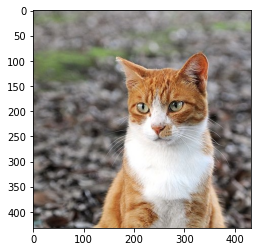

In [2]:

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),
    
])

image = Image.open('cat.jpg')
plt.imshow(image)

x_start = transform(image).unsqueeze(0)
print("Dimensions: ", x_start.shape)


Data vapas lane ka

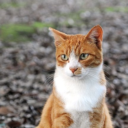

In [3]:

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

reverse_transform(x_start.squeeze())


We start the process of adding noise in the image

In [4]:
import torch.nn.functional as F
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


In [5]:
timesteps = 250

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


In [6]:
sqrt_recipm1_alphas_cumprod = torch.sqrt(
        1.0 / alphas_cumprod - 1)
sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / alphas_cumprod)

In [7]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


In [8]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image


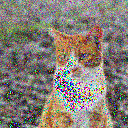

In [9]:
# take time step
t = torch.tensor([40])

get_noisy_image(x_start, t)

One step at a time noise images visual

In [10]:

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(12,3), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()


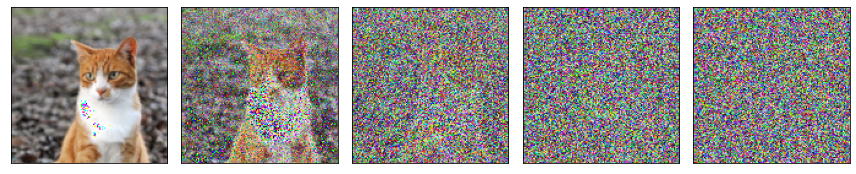

In [11]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])


Model Definition 

In [12]:
from unet import Unet

In [13]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss


In [26]:
from datasets import load_dataset

data_path = Path('data') / 'celebA'

# # load dataset from the hub
# if not data_path.exists():
#     dataset_url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz

#     ! wget {dataset_url} -P {data_path.parent}
#     ! tar xvf {data_path.parent / '17flowers.tgz'} -C {data_path.parent}
#     ! mv {data_path.parent / 'jpg'} {data_path}
#     ! rm {data_path.parent / '17flowers.tgz'}
    
dataset = torchvision.datasets.CelebA(data_path, download=True)

image_size = 96
channels = 3
batch_size = 32


RuntimeError: The daily quota of the file img_align_celeba.zip is exceeded and it can't be downloaded. This is a limitation of Google Drive and can only be overcome by trying again later.

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.Resize(image_size),
            transforms.RandomCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")
# .filter(lambda x: x["label"] in [0, 2, 3, 4, 6])

# create dataloader
dataloader = DataLoader(
    transformed_dataset["train"],
    num_workers=6,
    prefetch_factor=2,
    pin_memory=True,
    batch_size=batch_size,
    shuffle=True)


In [ ]:
batch = next(iter(dataloader))
tensors = batch['pixel_values']
m = 3
n = 3
fig = plt.figure(figsize=(4*m, 4*n))
for i in range(m * n):
    ax = fig.add_subplot(n , m , i + 1)
    if i == 0:
        print(tensors[i].shape)
    image = tensors[i].permute(1,2,0).cpu().numpy()
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])

    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()

In [ ]:
batch = next(iter(dataloader))
print(batch.keys())


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000


In [ ]:
from torch.optim import Adam

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=3e-4)


In [ ]:
from torchsummary import summary
summary(model)
None

In [ ]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    #plt.imshow(img.cpu().resize(32,32))
    #plt.show()
    imgs = []

    for i in reversed(range(0, timesteps)):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


In [ ]:
def plotSampledImages(model, image_size, channels, batch_size=16, m = 4, n = 4):
  samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels)
  
  # sampling = np.random.choice(len(samples[-1]), n*m, replace=False)
  # print(sampling)
  # tensors = np.random.choice(, size, replace=False)

  fig = plt.figure(figsize=(n*3,m*3))
  for j in range(m*n):
    ax = fig.add_subplot(m , n , j + 1)
    image = samples[-1][j].reshape(image_size, image_size, 3)
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])

    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
  return fig

In [ ]:
from torchvision.utils import save_image
from tqdm.auto import tqdm
from datetime import datetime


epochs = 10
l=[]

timestamp = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')

for epoch in tqdm(range(epochs)):
  for step, batch in enumerate(dataloader):
    optimizer.zero_grad()

    batch_size = batch["pixel_values"].shape[0]
    batch = batch["pixel_values"].to(device)

    # Algorithm 1 line 3: sample t uniformally for every example in the batch
    t = torch.randint(0, timesteps, (batch_size,), device=device).long()

    loss = p_losses(model, batch, t, loss_type="huber")
    l.append(loss.cpu().detach().numpy() )
    if step % 80 == 0:
      print(f"Step: {step} | Loss: {loss.item()}")

    loss.backward()
    optimizer.step()

  # save generated images
  print(f"Saving Images at Epoch {epoch+1}")
  fig = plotSampledImages(model, image_size, channels=channels)
  fig.savefig((results_folder / f'{timestamp}-sample-{epoch+1}.png').as_posix(), bbox_inches='tight')
  plt.close(fig)


In [ ]:
plt.plot(l)
plt.yscale('log')
plt.show()

In [ ]:
fig = plotSampledImages(model, image_size, channels)
fig.show()

In [ ]:
model_path = Path('models')
if not model_path.exists():
    !mkdir {model_path.as_posix()}

torch.save(model.state_dict(), f'models/{timestamp}')

In [ ]:
# model = Unet(
#     dim=image_size,
#     channels=channels,
#     dim_mults=(1, 2, 4,)
# )
# model.to(device)
# model.load_state_dict(torch.load(f'models/2022-12-14-19:47:04'))
# model.eval()


In [ ]:
fig = plotSampledImages(model, image_size, channels)
fig.show()

In [ ]:
img = dataset['train']['image'][3]
img_array = np.array(img.convert("RGB"))
plt.imshow(img_array)


In [ ]:
masks_path = Path("masks")
masks = [np.array(Image.open(i).convert("L").resize(img_array.shape)) for i in masks_path.glob("*")]
masks = [(i > 128) * 1 for i in masks]

In [ ]:
f, axs = plt.subplots(1, len(masks), sharey=True, figsize=(12, 8))

for i in range(len(masks)):
    axs[i].imshow(masks[i], cmap="gray")


In [ ]:
def get_schedule_jump(t_T, n_sample, jump_length, jump_n_sample,
                      jump2_length=1, jump2_n_sample=1,
                      jump3_length=1, jump3_n_sample=1,
                      start_resampling=100000000):

    jumps = {}
    for j in range(0, t_T - jump_length, jump_length):
        jumps[j] = jump_n_sample - 1

    jumps2 = {}
    for j in range(0, t_T - jump2_length, jump2_length):
        jumps2[j] = jump2_n_sample - 1

    jumps3 = {}
    for j in range(0, t_T - jump3_length, jump3_length):
        jumps3[j] = jump3_n_sample - 1

    t = t_T
    ts = []

    while t >= 1:
        t = t-1
        ts.append(t)

        if (
            t + 1 < t_T - 1 and
            t <= start_resampling
        ):
            for _ in range(n_sample - 1):
                t = t + 1
                ts.append(t)

                if t >= 0:
                    t = t - 1
                    ts.append(t)

        if (
            jumps3.get(t, 0) > 0 and
            t <= start_resampling - jump3_length
        ):
            jumps3[t] = jumps3[t] - 1
            for _ in range(jump3_length):
                t = t + 1
                ts.append(t)

        if (
            jumps2.get(t, 0) > 0 and
            t <= start_resampling - jump2_length
        ):
            jumps2[t] = jumps2[t] - 1
            for _ in range(jump2_length):
                t = t + 1
                ts.append(t)
            jumps3 = {}
            for j in range(0, t_T - jump3_length, jump3_length):
                jumps3[j] = jump3_n_sample - 1

        if (
            jumps.get(t, 0) > 0 and
            t <= start_resampling - jump_length
        ):
            jumps[t] = jumps[t] - 1
            for _ in range(jump_length):
                t = t + 1
                ts.append(t)
            jumps2 = {}
            for j in range(0, t_T - jump2_length, jump2_length):
                jumps2[j] = jump2_n_sample - 1

            jumps3 = {}
            for j in range(0, t_T - jump3_length, jump3_length):
                jumps3[j] = jump3_n_sample - 1

    ts.append(-1)
    return ts

schedule1 = {'t_T': 200,
               'n_sample': 1,
               'jump_length': 10, 'jump_n_sample': 10}



schedule2 = {'t_T': 200,
               'n_sample': 1,
               'jump_length': 10, 'jump_n_sample': 5}

plt.plot(get_schedule_jump(**schedule1))
plt.plot(get_schedule_jump(**schedule2))

In [ ]:
@torch.no_grad()
def p_sample_with_mask(model, inp, x, keep_mask, t, t_index):

    alpha_cumprod_t = extract(
        alphas_cumprod, t, x.shape)

    gt_weight = torch.sqrt(alpha_cumprod_t)
    gt_part = gt_weight * inp

    noise_weight = torch.sqrt((1 - alpha_cumprod_t))
    noise_part = noise_weight * torch.randn_like(x)

    weighed_gt = gt_part + noise_part

    x = (
        keep_mask * (
            weighed_gt
        )
        +
        (1 - keep_mask) * (
            x
        )
    )


    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )

    sqrt_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )

    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_output = model(x, t)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t *  model_output / sqrt_one_minus_alphas_cumprod_t
    )

    pred_x0 = extract(sqrt_recip_alphas_cumprod, t, x.shape) * x \
            - extract(sqrt_recipm1_alphas_cumprod, t, x.shape) * model_output
    # pred_x0 = weighed_gt
    
    if t_index == 0:
        newx = model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        newx = model_mean + torch.sqrt(posterior_variance_t) * noise
    return newx, pred_x0.clamp(-1,1)

def undo(img_after, t):
    beta = extract(betas, t, img_after.shape)

    return torch.sqrt(1 - beta) * img_after + \
            torch.sqrt(beta) * torch.randn_like(img_after)

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop_with_mask(model, img, mask, schedule = list(reversed(range(0, timesteps)))):
    device = next(model.parameters()).device

    img = torch.Tensor(img).unsqueeze(0).unsqueeze(0).to(device)
    mask = torch.Tensor(mask).unsqueeze(0).unsqueeze(0).to(device)
#     print(img.shape)
    b = img.shape[0]

    # xs = []
    img_after = torch.randn(img.shape, device=device)
    time_pairs = list(zip(schedule[:-1], schedule[1:]))

    for t_last, t_cur in time_pairs:
        t_last_t = torch.full((b,), t_last, device=device, dtype=torch.long)
        if t_cur < t_last:
            img_before = img_after.clone()
            img_after, pred_0 = p_sample_with_mask(model,img, img_before, mask, t_last_t, t_last)
            # xs.append(img_after.cpu().numpy())
        else:
            img_after = undo(img_after, t=t_last_t+1)
            # pred_xstart = out["pred_xstart"]
    return pred_0.cpu().numpy()


In [ ]:
img = dataset['train']['image'][3]
img_array = np.array(img.convert("L"))
sample_count = 5

fig, axs = plt.subplots(len(masks), sample_count + 1, figsize=(6*10, 5*10))
for i, mask_array in enumerate(tqdm(masks)):
    ax_row = axs[i]
    masked_img_array = img_array * mask_array
    ax_row[0].imshow(masked_img_array)
    ax_row[0].axis('off')

    for i in range(sample_count):
        sample_image = p_sample_loop_with_mask(model, (masked_img_array/128)-1, mask_array)
        ax_row[i+1].imshow((sample_image[0][0]+1)/2)
        ax_row[i+1].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [ ]:
img = dataset['train']['image'][3]
img_array = np.array(img.convert("L"))
sample_count = 5

fig, axs = plt.subplots(len(masks), sample_count + 1, figsize=(6*10, 5*10))
for i, mask_array in enumerate(tqdm(masks)):
    ax_row = axs[i]
    masked_img_array = img_array * mask_array
    ax_row[0].imshow(masked_img_array)
    ax_row[0].axis('off')

    for i in range(sample_count):
        sample_image = p_sample_loop_with_mask(model, (masked_img_array/128)-1, mask_array, schedule=get_schedule_jump(**schedule1))
        ax_row[i+1].imshow((sample_image[0][0]+1)/2)
        ax_row[i+1].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [ ]:
# img = dataset['train']['image'][3]
# img_array = np.array(img.convert("L"))
# sample_count = 5

# fig, axs = plt.subplots(len(masks), sample_count + 1, figsize=(12, 8))
# plt.axis('off')
# for i, mask_array in enumerate(masks):
#     ax_row = axs[i]
#     masked_img_array = img_array * mask_array
#     ax_row[0].imshow(masked_img_array)
#     for i in range(sample_count):
#         sample_image = p_sample_loop_with_mask(model, (masked_img_array/128)-1, mask_array, schedule=get_schedule_jump(**schedule2))
#         ax_row[i+1].imshow((sample_image[0][0]+1)/2)

In [ ]:
# img = dataset['train'].filter(lambda x: x["label"] in [0, 2])['image'][10]
# img_array = np.array(img.convert("L"))
# mask_array = np.ones(img_array.shape)
# mask_array[10:, :] = 0

# masked_img_array = img_array * mask_array
# plt.imshow(masked_img_array)

In [ ]:
# image = p_sample_loop_with_mask(model, (masked_img_array/128)-1, mask_array, schedule=get_schedule_jump(**schedule1))
# plt.imshow((image[0][0]+1)/2)

In [ ]:
# image = p_sample_loop_with_mask(model, (masked_img_array/128)-1, mask_array, schedule=get_schedule_jump(**schedule2))
# plt.imshow((image[0][0]+1)/2)